# Project Title: Moving Target Defense Against Membership Inference Attacks in Machine Learning

## Training

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import pickle
import os
from torch.utils.data import Subset, TensorDataset
import numpy as np
from torch_geometric.loader import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\xxyou\AppData\Local\Temp\ipykernel_24648\2076108973.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
os.mkdir("models")
os.mkdir("data")

**Data Preparation & Division:** I loaded the data and preprocessed some modification using predefined functions. Then to train the shadow model. I took a subset of 10% of the Cifar-10 training dataset for training and a disjoint subset (equal 10%) for testing. Now that the data is ready in the data loader.

In [2]:
# Loading the dataset
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
total_samples = len(trainset)
subset_size = int(total_samples * 0.1)
num_classes = 10
samples_per_class = subset_size // num_classes

subset1_indices = []
subset2_indices = []

for digit in range(num_classes):
    digit_indices = [i for i, (_, label) in enumerate(trainset) if label == digit]
    sampled_indices = torch.randperm(len(digit_indices))[:samples_per_class]
    subset1_indices.extend(digit_indices[idx] for idx in sampled_indices)

remaining_indices = list(set(range(total_samples)) - set(subset1_indices))

subset2_indices = torch.randperm(len(remaining_indices))[:subset_size]

subset1 = Subset(trainset, subset1_indices)
subset2 = Subset(trainset, np.array(remaining_indices)[list(subset2_indices.detach().numpy())])
#save subsets
with open('data/train_subset.pickle', 'wb') as handle:
    pickle.dump(subset1, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/test_subset.pickle', 'wb') as handle:
    pickle.dump(subset2, handle, protocol=pickle.HIGHEST_PROTOCOL)
#load subsets
with open('data/test_subset.pickle', 'rb') as handle:
    subset2 = pickle.load(handle)
with open('data/train_subset.pickle', 'rb') as handle:
    subset1 = pickle.load(handle)
    
# create dataloaders for training and test datasets
train_dataloader = DataLoader(dataset=subset1, batch_size=128, shuffle=True)
test_dataloader = DataLoader(dataset=subset2, batch_size=128, shuffle=True)

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [72]:
# Loading the model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.root = Root(2*out_channels, out_channels)
        if level == 1:
            self.left_tree = block(in_channels, out_channels, stride=stride)
            self.right_tree = block(out_channels, out_channels, stride=1)
        else:
            self.left_tree = Tree(block, in_channels,
                                  out_channels, level=level-1, stride=stride)
            self.right_tree = Tree(block, out_channels,
                                   out_channels, level=level-1, stride=1)

    def forward(self, x):
        out1 = self.left_tree(x)
        out2 = self.right_tree(out1)
        out = self.root([out1, out2])
        return out


class SimpleDLA(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(SimpleDLA, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


The first step after that the data is ready consists of training the shadow model to mimic the oracle model (the model that we want to attack). 

In [4]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    # Calculate average loss and accuracy
    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = 100. * correct / total
    
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    print('\nEpoch: %d, Training Loss: %.4f, Training Accuracy: %.2f%%' % (epoch, avg_train_loss, train_accuracy))

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # Calculate average loss and accuracy
        avg_test_loss = test_loss / len(test_dataloader)
        test_accuracy = 100. * correct / len(test_dataloader.dataset)
        
        # Append to lists
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            avg_test_loss, correct, len(test_dataloader.dataset), test_accuracy))
        
net = SimpleDLA().to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr= 0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

for epoch in range(201):
    train(epoch)
    test(epoch)
    scheduler.step()

# Save model
torch.save(net.state_dict(), 'models/model.pth')



Epoch: 0, Training Loss: 2.2704, Training Accuracy: 13.72%

Test set: Average loss: 2.3051, Accuracy: 536/5000 (11%)

Epoch: 1, Training Loss: 2.1593, Training Accuracy: 18.32%

Test set: Average loss: 2.1274, Accuracy: 973/5000 (19%)

Epoch: 2, Training Loss: 2.0205, Training Accuracy: 23.56%

Test set: Average loss: 1.9965, Accuracy: 1200/5000 (24%)

Epoch: 3, Training Loss: 1.9053, Training Accuracy: 28.18%

Test set: Average loss: 1.8876, Accuracy: 1407/5000 (28%)

Epoch: 4, Training Loss: 1.8401, Training Accuracy: 31.14%

Test set: Average loss: 1.8306, Accuracy: 1476/5000 (30%)

Epoch: 5, Training Loss: 1.7923, Training Accuracy: 33.96%

Test set: Average loss: 1.7962, Accuracy: 1615/5000 (32%)

Epoch: 6, Training Loss: 1.7300, Training Accuracy: 34.54%

Test set: Average loss: 1.7804, Accuracy: 1582/5000 (32%)

Epoch: 7, Training Loss: 1.7021, Training Accuracy: 35.74%

Test set: Average loss: 1.7406, Accuracy: 1656/5000 (33%)

Epoch: 8, Training Loss: 1.6674, Training Accurac

After training the shadow model I was able to achieve the maximum percentage of accuracy that it can reach. It was 66% accurate (due to only 10% of the dataset to train which is considered very small size)

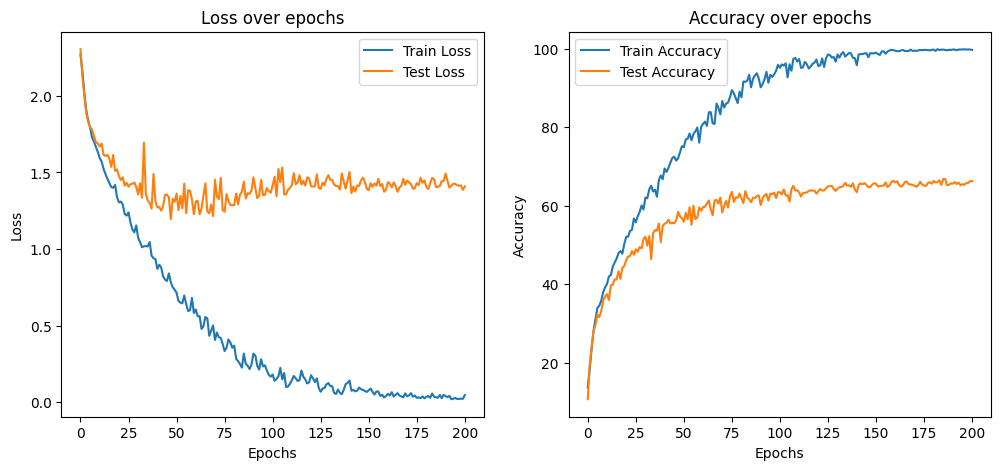

In [5]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Next part consists of extracting the probabilities from the shadow model using the 2 disjoint subsets(10% that is used for training, we will call it **seen data** and another 10% that is used for testing, we will call it **unseen data**) and save them in a data frame (csv file).

In [74]:
model = SimpleDLA()

# Load the saved model
model.load_state_dict(torch.load('models/model.pth'))
def prob_extraction(model, device, test_loader,label):
    model = model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    all_probs = []  
    all_targets = []  
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred_probs = F.softmax(output, dim=1)  
            all_probs.extend(pred_probs.tolist())  
            all_targets.extend([label for counter in range(len(target))])  
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # Calculate accuracy and loss
    accuracy = 100. * correct / len(test_loader.dataset)
    avg_loss = test_loss

    # Create a DataFrame
    df = pd.DataFrame(all_probs, columns=[f'prob_{i+1}' for i in range(len(all_probs[0]))])
    df['Target'] = all_targets
    return accuracy, avg_loss, df

accuracy, avg_loss, df = prob_extraction(model, device, test_dataloader,1)
accuracy, avg_loss, df_seen = prob_extraction(model, device, train_dataloader,0)
combined_df = pd.concat([df, df_seen], ignore_index=True)
indices = np.arange(len(combined_df))
np.random.shuffle(indices)  
shuffled_df = combined_df.iloc[indices].reset_index(drop=True)
shuffled_df.to_csv('shuffled_data.csv', index=False)


Test set: Average loss: -5.8145, Accuracy: 3307/5000 (66%)


Test set: Average loss: -9.0130, Accuracy: 4997/5000 (100%)



The next part consists of training the oracle model(in real life, we suppose it is already trained and deployed), we used the same methodology as the shadow model to train it. The only difference is that it is trained on more data samples.

In [7]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

net = SimpleDLA().to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr= 0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(50):
    train(epoch)
    test(epoch)
    scheduler.step()
    
torch.save(net.state_dict(), 'models/Oraclemodel.pth')

Files already downloaded and verified
Files already downloaded and verified

Epoch: 0, Training Loss: 1.8858, Training Accuracy: 28.86%

Test set: Average loss: 1.6358, Accuracy: 3919/10000 (39%)

Epoch: 1, Training Loss: 1.4798, Training Accuracy: 45.18%

Test set: Average loss: 1.3729, Accuracy: 4967/10000 (50%)

Epoch: 2, Training Loss: 1.2478, Training Accuracy: 54.54%

Test set: Average loss: 1.2353, Accuracy: 5509/10000 (55%)

Epoch: 3, Training Loss: 1.0711, Training Accuracy: 61.59%

Test set: Average loss: 0.9932, Accuracy: 6412/10000 (64%)

Epoch: 4, Training Loss: 0.9389, Training Accuracy: 66.59%

Test set: Average loss: 1.0646, Accuracy: 6320/10000 (63%)

Epoch: 5, Training Loss: 0.8394, Training Accuracy: 70.18%

Test set: Average loss: 0.8221, Accuracy: 7147/10000 (71%)

Epoch: 6, Training Loss: 0.7554, Training Accuracy: 73.32%

Test set: Average loss: 0.7258, Accuracy: 7496/10000 (75%)

Epoch: 7, Training Loss: 0.6844, Training Accuracy: 76.09%

Test set: Average loss:

After training the oracle model, we were able to achieve 89% accuracy which measures the percentage of correctly classified samples. 

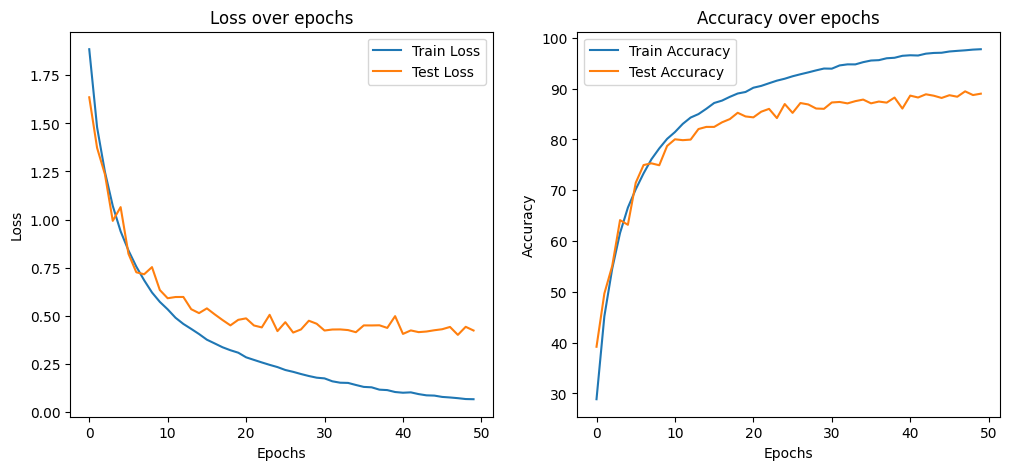

In [8]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Next part consists of loading the probabilities (csv file that was previously saved) which will serve as input to the binary classifier (we will divide them into 80% train and 20% test) and then train a binary classifier(which later will serve to infer members).

Epoch 1, Loss: 0.6917, Accuracy: 0.5429
Epoch 2, Loss: 0.6715, Accuracy: 0.6378
Epoch 3, Loss: 0.6079, Accuracy: 0.6661
Epoch 4, Loss: 0.5576, Accuracy: 0.7023
Epoch 5, Loss: 0.5471, Accuracy: 0.7119
Epoch 6, Loss: 0.5467, Accuracy: 0.7067
Epoch 7, Loss: 0.5465, Accuracy: 0.7053
Epoch 8, Loss: 0.5439, Accuracy: 0.7086
Epoch 9, Loss: 0.5429, Accuracy: 0.7089
Epoch 10, Loss: 0.5455, Accuracy: 0.7117
Epoch 11, Loss: 0.5470, Accuracy: 0.7056
Epoch 12, Loss: 0.5412, Accuracy: 0.7144
Epoch 13, Loss: 0.5402, Accuracy: 0.7149
Epoch 14, Loss: 0.5417, Accuracy: 0.7160
Epoch 15, Loss: 0.5401, Accuracy: 0.7119
Epoch 16, Loss: 0.5397, Accuracy: 0.7133
Epoch 17, Loss: 0.5395, Accuracy: 0.7150
Epoch 18, Loss: 0.5407, Accuracy: 0.7099
Epoch 19, Loss: 0.5378, Accuracy: 0.7125
Epoch 20, Loss: 0.5383, Accuracy: 0.7204
Epoch 21, Loss: 0.5385, Accuracy: 0.7167
Epoch 22, Loss: 0.5411, Accuracy: 0.7126
Epoch 23, Loss: 0.5380, Accuracy: 0.7186
Epoch 24, Loss: 0.5390, Accuracy: 0.7146
Epoch 25, Loss: 0.5410, A

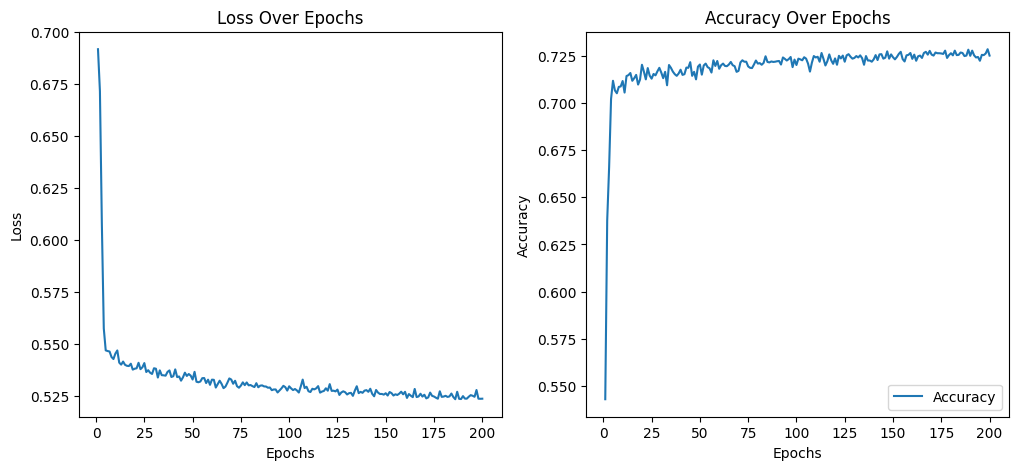

In [75]:
df = pd.read_csv("shuffled_data.csv")

# Prepare the dataset
X = df.drop('Target', axis=1).values  
y = df['Target'].values

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)

y_train_tensor = torch.tensor(y_train, dtype=torch.float)  
y_test_tensor = torch.tensor(y_test, dtype=torch.float)  

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


class NNWithoutDropout(nn.Module):
    def __init__(self):
        super(NNWithoutDropout, self).__init__()
        self.fc1 = nn.Linear(10, 128)  
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)  

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))  
        return x

model = NNWithoutDropout()
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0005)  

def train_model(model, criterion, optimizer, train_loader, epochs=20):
    model.train()
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs).squeeze()  # Assuming outputs need to be squeezed
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Convert outputs to predicted class (0 or 1)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)
        
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    print("Training complete.")
    
    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), accuracies, label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    
    plt.legend()
    plt.show()
    
    return model

model=train_model(model, criterion, optimizer, train_loader, epochs=200)

Now that the binary classifier is trained, we have 20% of the data as a test. Using this 20%, we will assess the model's efficiency to infer members(Attack success percentage) from given model's probabilities of the 20% input. This will serve afterwards as an attack tool.

In [76]:
def evaluate_model(model, test_loader):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            preds = outputs.round()  

            true_labels.extend(labels.numpy())
            predictions.extend(preds.numpy())

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    
    conf_matrix = confusion_matrix(true_labels, predictions)
    TP = conf_matrix[0, 0]
    FP = conf_matrix[1, 0]
    FN = conf_matrix[0, 1]  
    TN = conf_matrix[1, 1]
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP/ (FP + TN) if (FP +TN) > 0 else 0
    print(conf_matrix)
    print(f"FPR {FPR * 100:.2f}%")
    print(f"Attack success: {TPR * 100:.2f}%")
    print("Inferred members", TP)
    print("Non-Inferred members",FN)
    # Plotting
    categories = ['Inferred members ', 'Non-Inferred members']
    values = [TP, FN]
    plt.figure(figsize=(8, 4))
    plt.bar(categories, values, color=['red', 'green'])
    plt.title('Inferred members vs. Non-Inferred members')
    plt.ylabel('Count')
    plt.show()

[[922 108]
 [419 551]]
FPR 43.20%
Attack success: 89.51%
Inferred members 922
Non-Inferred members 108


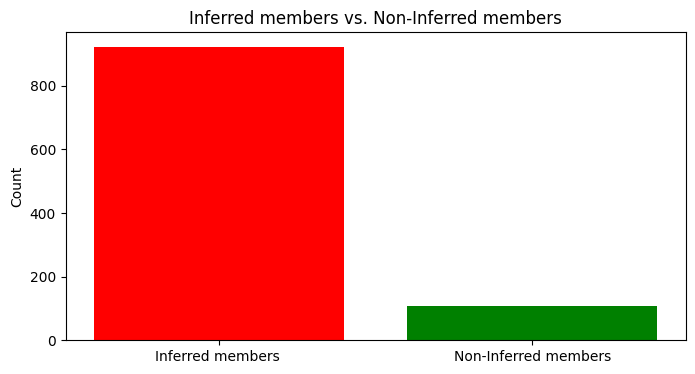

In [77]:
#20% of the data to test
evaluate_model(model, test_loader)

## Attack

Now as we have everything trained, ready and set, we can launch the attack on the oracle model. As a result, the attack success percentage is 87%  and we were able to infer 43498 members out of 50000. (6502 non-Inferred members).

Files already downloaded and verified
Files already downloaded and verified

Test set: Average loss: -10.3893, Accuracy: 49032/50000 (98%)


Test set: Average loss: -10.5024, Accuracy: 8901/10000 (89%)

[[41889  8111]
 [ 7590  2410]]
FPR 75.90%
Attack success: 83.78%
Inferred members 41889
Non-Inferred members 8111


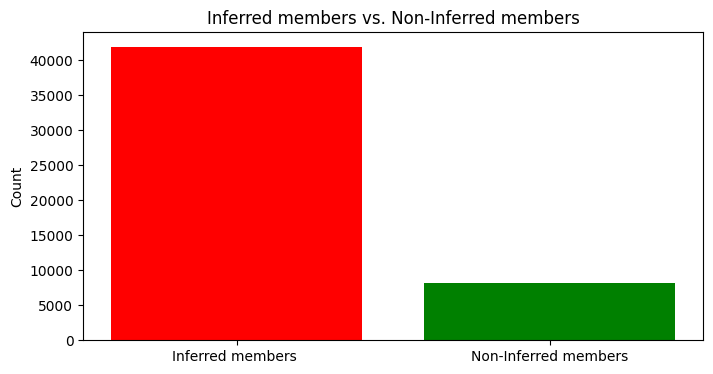

In [78]:
modelor = SimpleDLA()

# Load the saved model 
modelor.load_state_dict(torch.load('models/Oraclemodel.pth'))

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
accuracy, avg_loss, df_seen = prob_extraction(modelor, device, train_dataloader,0)
accuracy, avg_loss, df = prob_extraction(modelor, device, test_dataloader,1)

combined_df = pd.concat([df, df_seen], ignore_index=True)
indices = np.arange(len(combined_df))
np.random.shuffle(indices)  
shuffled_df = combined_df.iloc[indices].reset_index(drop=True)
shuffled_df.to_csv('oraclemodeldata.csv', index=False)
X = shuffled_df.drop('Target', axis=1).values  
y = shuffled_df['Target'].values



X_test_tensor = torch.tensor(X, dtype=torch.float)
y_test_tensor = torch.tensor(y, dtype=torch.float)  

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

oraclemodeldata = pd.read_csv("oraclemodeldata.csv")

X = oraclemodeldata.drop('Target', axis=1).values  
y = oraclemodeldata['Target'].values

X_test_tensor = torch.tensor(X, dtype=torch.float)
y_test_tensor = torch.tensor(y, dtype=torch.float)  

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

evaluate_model(model, test_loader)

## Defense Methods:

### Moving Target Defense (Most promising  one)

The defending strategy is known as **Moving Target defense** consists of manipulating the max probability by decreasing it with a random number however it stays the **max prob** to keep the model accurate and efficient and distribute the reduction across the other probabilities by their weights which is also randomly generated. The attack success went from 87% to 0% after defending. 

In [53]:
def generate_and_adjust_weights():

    weights = np.random.rand(9)
    weights /= weights.sum()
    if np.random.rand() < 0.5:  
        idx_to_adjust = np.random.randint(0, 9)
        weights[idx_to_adjust] = np.random.uniform(0.4, 0.7)
        weights /= weights.sum()
    
    return weights

oraclemodeldata = pd.read_csv("oraclemodeldata.csv")

def adjust_probs(row):
    # Extract the probabilities
    probs = row[["prob_1", "prob_2", "prob_3", "prob_4", "prob_5", 
                 "prob_6", "prob_7", "prob_8", "prob_9", "prob_10"]].values
    max_prob_index = np.argmax(probs)
    
    # Calculate the amount to reduce from the maximum probability
    reduction_amount = np.random.uniform(0.1, 0.4)
    adjusted_max_prob = max(0, probs[max_prob_index] - reduction_amount)  # Ensure it doesn't go below 0
    
    weights = generate_and_adjust_weights()
    # Distribute the reduction across the other probabilities
    for i, prob in enumerate(probs):
        if i != max_prob_index:
            probs[i] += (reduction_amount * weights[i-1] if i > max_prob_index else reduction_amount * weights[i])
    
    # Ensure the probabilities are within [0,1] after redistribution
    probs = np.clip(probs, 0, 1)
    
    # Ensure the adjusted max probability is still the highest
    probs[max_prob_index] = adjusted_max_prob
    
    row[["prob_1", "prob_2", "prob_3", "prob_4", "prob_5", 
         "prob_6", "prob_7", "prob_8", "prob_9", "prob_10"]] = probs
    
    return row

df_adjusted = oraclemodeldata.apply(adjust_probs, axis=1)
df_adjusted.to_csv('test4.csv', index=False)

[[    0 50000]
 [    0 10000]]
FPR 0.00%
Attack success: 0.00%
Inferred members 0
Non-Inferred members 50000


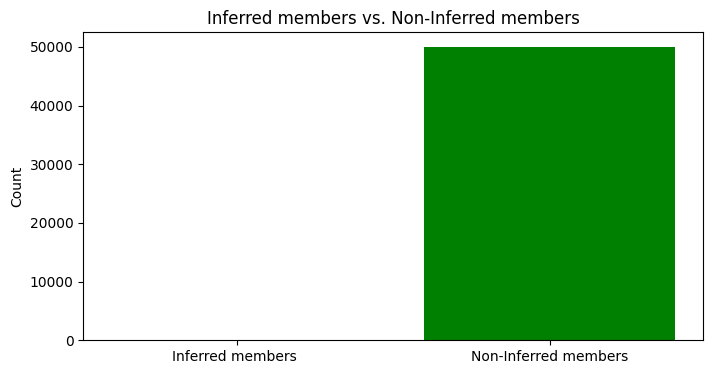

In [54]:
updated_oraclemodeldata = pd.read_csv("test4.csv")

X = updated_oraclemodeldata.drop('Target', axis=1).values  
y = updated_oraclemodeldata['Target'].values

X_test_tensor = torch.tensor(X, dtype=torch.float)
y_test_tensor = torch.tensor(y, dtype=torch.float) 

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

evaluate_model(model, test_loader)

### Defense 2 (efffective but susceptible for reverse engineering)

[[    0 50000]
 [    0 10000]]
FPR 0.00%
Attack success: 0.00%
Inferred members 0
Non-Inferred members 50000


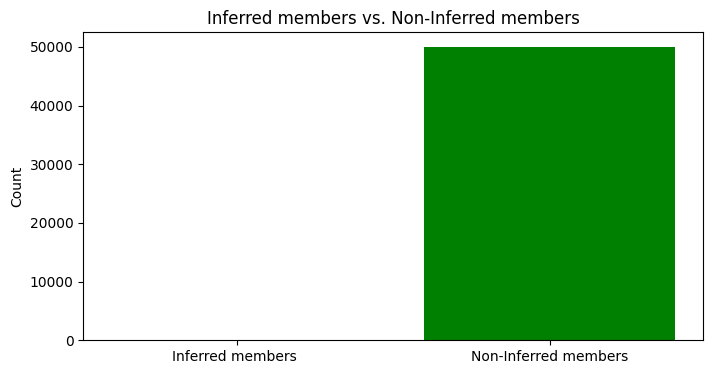

In [79]:
#method 2 (decrease the max by a certain value and distribute the remaining accross others equally)
oraclemodeldata = pd.read_csv("oraclemodeldata.csv")

def adjust_probabilities(row):
    # Extract probabilities from the row
    probs = row[['prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5', 
                 'prob_6', 'prob_7', 'prob_8', 'prob_9', 'prob_10']]
    
    # Find the max probability and its index
    max_prob = probs.max()
    max_index = probs.idxmax()
    
    # Decrease the max probability by 0.1
    decreased_max_prob = max_prob - 0.1
    amount_to_distribute = 0.1 / 9
    
    # Update probabilities
    for col in probs.index:
        if col != max_index:
            row[col] += amount_to_distribute
        else:
            row[col] = decreased_max_prob
            
    return row


oraclemodeldata= oraclemodeldata.apply(adjust_probabilities, axis=1)


oraclemodeldata.to_csv('test2.csv', index=False)

updated_oraclemodeldata = pd.read_csv("test2.csv")

X = updated_oraclemodeldata.drop('Target', axis=1).values  
y = updated_oraclemodeldata['Target'].values

X_test_tensor = torch.tensor(X, dtype=torch.float)
y_test_tensor = torch.tensor(y, dtype=torch.float) 

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

evaluate_model(model, test_loader)

### Ineffective Defense

[[43576  6424]
 [ 7922  2078]]
FPR 79.22%
Attack success: 87.15%
Inferred members 43576
Non-Inferred members 6424


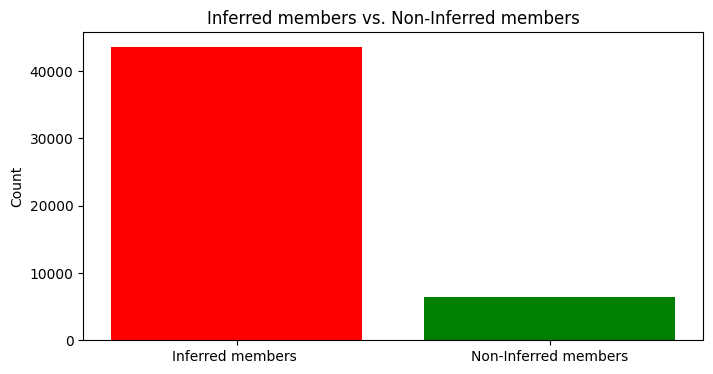

In [55]:
#Method 3 (extract max prob without changing its value and distribute the sum of others equally) 
oraclemodeldata = pd.read_csv("oraclemodeldata.csv")
# Extract columns for probability manipulation
prob_columns = [col for col in oraclemodeldata.columns if col.startswith('prob')]

# Calculate the maximum probability for each row
max_prob = oraclemodeldata[prob_columns].max(axis=1)

# Compute the remaining probability after subtracting the max probability
remaining_prob = 1 - max_prob

# Count the number of columns to redistribute probability
num_columns = len(prob_columns) - 1  # Excluding the target column

# Redistribute the remaining probability equally among all columns (excluding the max column)
redistributed_prob = remaining_prob / num_columns

# Iterate through each row
for index, row in oraclemodeldata.iterrows():
    max_col = row[prob_columns].idxmax()  # Find the column with the max probability
    for col in prob_columns:
        if col != max_col:  # Exclude the column with the max probability
            oraclemodeldata.at[index, col] = redistributed_prob[index]

# Ensure probabilities sum up to 1
oraclemodeldata[prob_columns] = oraclemodeldata[prob_columns].div(oraclemodeldata[prob_columns].sum(axis=1), axis=0)

# Save the updated data to a new CSV file
oraclemodeldata.to_csv('updated_oraclemodeldata.csv', index=False)

updated_oraclemodeldata = pd.read_csv("updated_oraclemodeldata.csv")

X = updated_oraclemodeldata.drop('Target', axis=1).values  
y = updated_oraclemodeldata['Target'].values

X_test_tensor = torch.tensor(X, dtype=torch.float)
y_test_tensor = torch.tensor(y, dtype=torch.float) 

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

evaluate_model(model, test_loader)

[[43774  6226]
 [ 7970  2030]]
FPR 79.70%
Attack success: 87.55%
Inferred members 43774
Non-Inferred members 6226


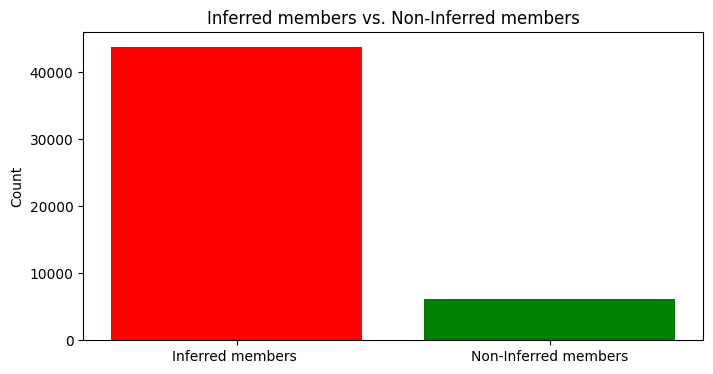

In [56]:
#method 4 (shuffle probabilities columns of each row with touching the max prob)
oraclemodeldata = pd.read_csv("oraclemodeldata.csv")
# Function to shuffle columns except for the max probability column
def shuffle_except_max(row):
    # Find the column name with the max probability
    max_prob_col = row[['prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5', 'prob_6', 'prob_7', 'prob_8', 'prob_9', 'prob_10']].idxmax()
    # Extract max probability value to keep it unchanged
    max_prob_value = row[max_prob_col]
    
    # Shuffle other probabilities
    other_probs = row[['prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5', 'prob_6', 'prob_7', 'prob_8', 'prob_9', 'prob_10']].drop(max_prob_col)
    shuffled_probs = np.random.permutation(other_probs.values)
    
    # Place the max probability back in its original position
    row[other_probs.index] = shuffled_probs
    row[max_prob_col] = max_prob_value
    
    return row

# Apply the function to each row
df = oraclemodeldata.apply(shuffle_except_max, axis=1)

# Save the updated DataFrame to a new CSV file
df.to_csv('test.csv', index=False)

updated_oraclemodeldata = pd.read_csv("test.csv")

X = updated_oraclemodeldata.drop('Target', axis=1).values  
y = updated_oraclemodeldata['Target'].values

X_test_tensor = torch.tensor(X, dtype=torch.float)
y_test_tensor = torch.tensor(y, dtype=torch.float) 

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

evaluate_model(model, test_loader)